### Installing Kaggle API

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shoaibhoque","key":"56d2243436039c0f4b459bf4670bfece"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


### Searching and getting the dataset

In [ ]:
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34         108893       1103  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11          14312        287  1.0              
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                        118MB  2023-07-11 04:21:24            884         31  1.0              
ibrahimkaratas/gtsrb-german-traffic-sign-recogniti

In [ ]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 98% 600M/612M [00:04<00:00, 120MB/s]
100% 612M/612M [00:04<00:00, 152MB/s]
/content


unzip and remove unnecessary files

In [ ]:
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

### Image Processing

checking the dimension of the images

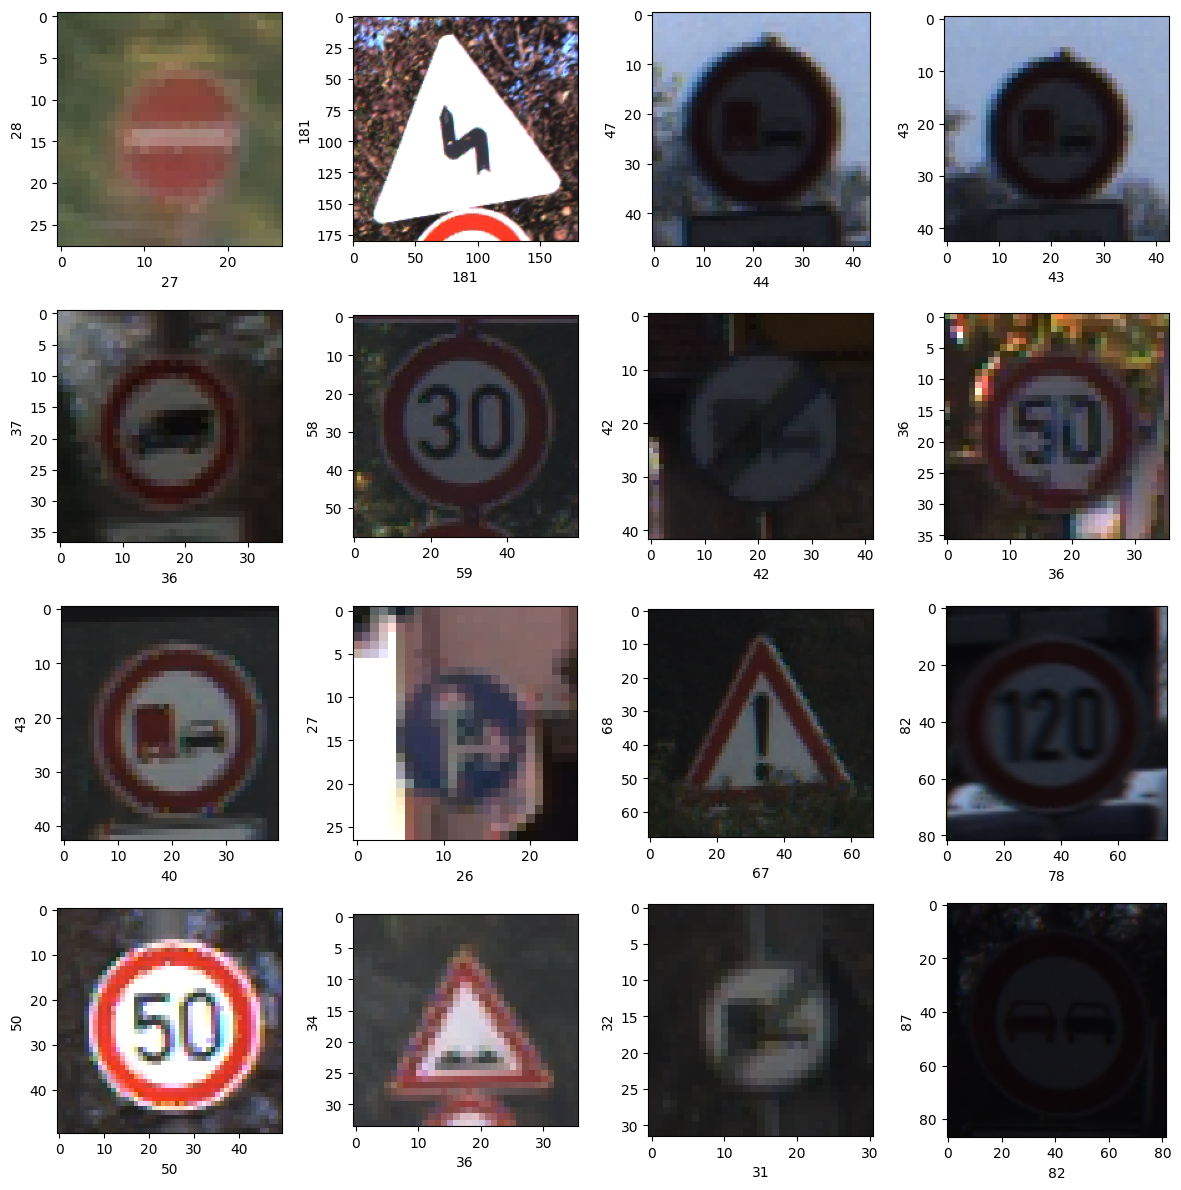

In [ ]:
plt.figure(figsize=(12,12))
path = 'traffic_sign_dataset/Test'
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

as we can see here the dimension of all images here are not same, since we need to take all dimensions into same format

In [ ]:
# calculate mean of all image dimensions
dim1 = []
dim2 = []

for i in range(43):
  labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
  image_path = os.listdir(labels)

  for x in image_path:
    img = imread(labels + '/' + x)
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])

In [ ]:
print ("Dimension 1 Mean: ", np.mean(dim1), "Dimension 2 Mean: ", np.mean(dim2))

Dimension 1 Mean:  50.328929582493814 Dimension 2 Mean:  50.83587951745773


Now we've got the average dimensions for all images is 50 by 50. So, now we'll reshape all image dimensions into (50,50)

In [ ]:
# Reshape images to (50,50)
images = []
label_id = []

for i in range(43):
  labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
  image_path = os.listdir(labels)

  for x in image_path:
    img = Image.open(labels + '/' + x)
    img = img.resize((50,50))
    img = np.array(img)
    images.append(img)
    label_id.append(i)



now we convert all the images and normalize them

In [ ]:
images = np.array(images)

images = images/255

In [ ]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [ ]:
images.shape

(39209, 50, 50, 3)

checking whether data is balanced or not

In [ ]:
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
Name: count, dtype: int64

### Split into train and validation data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, label_id, test_size=0.2, random_state=42)

converting the classes column into categorical

In [ ]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

### Creating and testing model

defining the model architecture. Here I'll define all the layers with their input shape kernel size, activation, etc.

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

compile the model using metrics, optimizer and loss as required and printing out the summary of the model.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Here I've used "sparse_categorical_crossentropy" in the loss function because so many categories as there are 43 categories of traffic sign in this dataset

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

#### Fit the model

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose = 2)

Epoch 1/50
246/246 - 210s - loss: 2.4857 - accuracy: 0.3215 - val_loss: 1.3152 - val_accuracy: 0.6579 - 210s/epoch - 853ms/step
Epoch 2/50
246/246 - 222s - loss: 1.1829 - accuracy: 0.6296 - val_loss: 0.4906 - val_accuracy: 0.8864 - 222s/epoch - 902ms/step
Epoch 3/50
246/246 - 218s - loss: 0.7682 - accuracy: 0.7532 - val_loss: 0.2895 - val_accuracy: 0.9424 - 218s/epoch - 887ms/step
Epoch 4/50
246/246 - 216s - loss: 0.5843 - accuracy: 0.8116 - val_loss: 0.2032 - val_accuracy: 0.9568 - 216s/epoch - 877ms/step
Epoch 5/50
246/246 - 221s - loss: 0.4901 - accuracy: 0.8403 - val_loss: 0.1576 - val_accuracy: 0.9660 - 221s/epoch - 897ms/step
Epoch 6/50
246/246 - 219s - loss: 0.4282 - accuracy: 0.8595 - val_loss: 0.1204 - val_accuracy: 0.9749 - 219s/epoch - 889ms/step
Epoch 7/50
246/246 - 220s - loss: 0.3788 - accuracy: 0.8754 - val_loss: 0.1020 - val_accuracy: 0.9823 - 220s/epoch - 894ms/step
Epoch 8/50
246/246 - 212s - loss: 0.3421 - accuracy: 0.8862 - val_loss: 0.0922 - val_accuracy: 0.9819 - 

### Evaluation

we will visualize the accuracy and loss per epoch. For this we will store the model history in the pandas dataframe and plot them.

<Axes: >

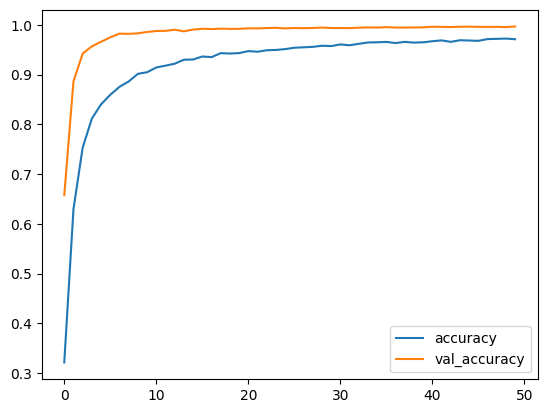

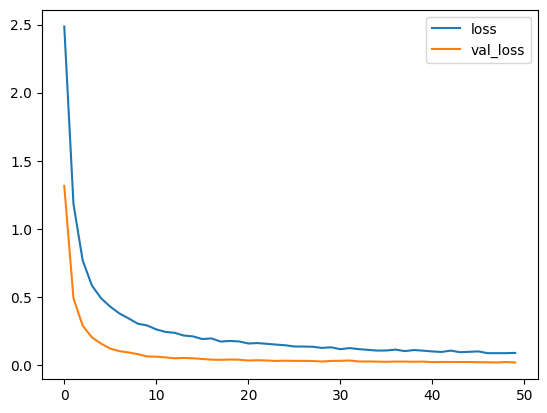

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

here we can clearly see that the accuracy increases and loss also decreases over the epochs

Now we'll create the variable which has path of test dataset. as we downloaded the dataset we found that their is a GT-final_test.csv file in the test images folder which cannot be processed. So, we wil remove that file

In [ ]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

rm: cannot remove 'traffic_sign_dataset/Test/GT-final_test.csv': No such file or directory


scale the test images and convert them into a numpy array and normalize them

In [ ]:
# Defining a function that will scale images

def scaling(test_images, test_path):
  images = []
  image_path = test_images

  for x in image_path:
    img = Image.open(test_path + '/' + x)
    img = img.resize((50,50))
    img = np.array(img)
    images.append(img)

  images = np.array(images)
  images = images/255

  return images

In [ ]:
test_images = scaling(sorted(os.listdir(test_path)), test_path)

In [ ]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [ ]:
y_pred = model.predict(test_images);
y_pred

395/395 [==============================] - 18s 45ms/step


array([[7.9191381e-30, 1.7956759e-28, 5.9418680e-24, ..., 3.8739934e-23,
        8.7851350e-23, 2.2291573e-16],
       [3.1828228e-22, 9.9999994e-01, 4.1861562e-20, ..., 3.8538353e-35,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.8660308e-07, 1.0085257e-04, 2.5493579e-04, ..., 3.1893043e-07,
        5.9082518e-06, 1.9206664e-05],
       [5.2435378e-12, 1.3320457e-07, 3.7286725e-08, ..., 1.2662274e-10,
        7.1867671e-15, 1.5627249e-08],
       [1.6324709e-15, 1.7261229e-10, 8.4220488e-08, ..., 8.7346010e-13,
        8.3273327e-14, 1.9103767e-11]], dtype=float32)

get all the image labels according to image class from kaggle

In [ ]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

In [ ]:
# Visualize test image
img = Image.open(test_path + '/00003.png')
img

In [ ]:
print("Original label : ",all_lables[y_test[3]])

Original label :  Turn right ahead


### Conclusion

We started with downloading the dataset, preprocessing it, created the model and found out the predictions using the model. During preprocessing we found that this dataset has 43 classes. Model reached an accuracy of 97% in just 50 epochs, we can further optimize the model using hyper parameter tuning and reach a higher accuracy.

### Scope

This model can be used in self driving cars which will enable them to automatically recognize traffic signs similarly the driver alert system inside cars will help and protect drivers by understanding the traffic signs around them.